In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import os

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient()
cluster.scale(20)

In [4]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:33439,Workers: 0
Dashboard: https://https://jupyterhub.hpc.ucar.edu/stable/user/dlawren/proxy/{port}/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
def get_params(keys,paramkey):
    params=[]
    minmaxs=[]
    for key in keys:
        ix     = paramkey.key==key
        params.append(paramkey.param[ix].values[0])
        minmaxs.append(paramkey.minmax[ix].values[0])
    return params,minmaxs

In [6]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [7]:
def get_ensemble(name,data_vars,htape,keys,paramkey):
    '''
    Returns a dataset comprising the given ensemble
    name  = 'CTL2020' or 'C285' or 'AF1905'
    data_vars, e.g. ['GPP','HR','AR']
    htape, e.g. 'h0' 0/1/2/3/4/5/7 available
    '''
    
    #define the directory structure and find files
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]

    def preprocess(ds):
        return ds[data_vars]

    #read in the dataset
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,preprocess=preprocess)

    #fix up time dimension
    if htape=='h0':
        ds['time'] = xr.cftime_range(str(2005),periods=120,freq='MS') #fix time bug
    
    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]

    #append some info about key/param/minmax
    params,minmaxs = get_params(keys,paramkey) 
    ds['key']    = xr.DataArray(keys,dims='ens')
    ds['param']  = xr.DataArray(params,dims='ens')
    ds['minmax'] = xr.DataArray(minmaxs,dims='ens')
    
    return ds

### CTL2010

In [8]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/firstpass.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la_orig = xr.open_dataset(la_file).landarea  #km2

In [9]:
#choose your subset of variables
data_vars = ['GPP','NPP','NBP','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','FCEV','FGEV','COL_FIRE_CLOSS','QHR','ALTMAX',
             'TWS','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']
data_vars = ['GPP','NPP','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','ALTMAX','QOVER','QDRAI',
             'SOILWATER_10CM','SNOWDP','TSOI_10CM','TLAI','FSR','FSH']

data_vars = ['GPP','NPP','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','QOVER','QDRAI',
             'SOILWATER_10CM','SNOWDP','TSOI_10CM','TLAI','FSR','FSH']


keys = paramkey.key
#read in the dataset
ds = get_ensemble('CTL2010',data_vars,'h0',keys,paramkey)
ds

<xarray.Dataset>
Dimensions:         (ens: 373, gridcell: 400, time: 120)
Coordinates:
  * ens             (ens) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
  * time            (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    GPP             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    NPP             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    AR              (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    HR              (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    EFLX_LH_TOT     (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FCTR            (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FAREA_BURNED    (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    TOTVEGC         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    TOTSOMC_1m      (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    QOVER           (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    QDRAI           (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    SOILWATER_10CM  (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    SNOWDP          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    TSOI_10CM       (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    TLAI            (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FSR             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    FSH             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 400), meta=np.ndarray>
    grid1d_lat      (gridcell) float64 ...
    grid1d_lon      (gridcell) float64 ...
    key             (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0398' 'OAAT0399'
    param           (ens) <U32 'default' 'taulnir' ... 'om_frac_sf'
    minmax          (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 04/26/21 15:05:00
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn08_CTL2010_PROD_001
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                CTL2010_OAAT0000_postSASUresta...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:     

In [10]:
def get_subset(ds,la_orig,region):
    #ix = (ds.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 60)
    if region=='permafrost':
        print, region
        ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > 60) & (ds.ALTMAX.isel(ens=0).max(dim='time')<2)
    
    if region=='amazon':
        print, region
        ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > -10) & (ds.grid1d_lat < 10) & (ds.grid1d_lon > 290) & (ds.grid1d_lon < 310)

    if region=='tropics':
        print, region
        ix = (ds.GPP.isel(ens=0).mean(dim='time')>0) & (ds.grid1d_lat > -15) & (ds.grid1d_lat < 15)
        
    if region=='global':
        ix = ds.GPP.isel(ens=0).mean(dim='time')>0

    plt.plot(ds.grid1d_lon,ds.grid1d_lat,'x')
    plt.plot(ds.grid1d_lon[ix],ds.grid1d_lat[ix],'x');
    nx=ix.sum()
    nx.values
    ix = ix.drop('ens')
    ds = ds.isel(gridcell=ix)
    la = la_orig.isel(gridcell=ix)

    return ds, la, ix

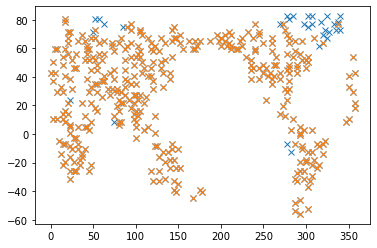

In [11]:
region = 'global'
ds,la,ix = get_subset(ds,la_orig,region)

In [12]:
uniques = np.unique(ds.param)
ix = uniques=='default'
uniques = uniques[~ix]

In [13]:
def find_pair(da,params,minmax,p):
    '''
    returns a subset of da, corresponding to parameter-p
        the returned pair corresponds to [p_min,p_max]
    '''
    ixmin = np.logical_and(params==p,minmax=='min')
    ixmax = np.logical_and(params==p,minmax=='max')
    
    #sub in default if either is missing
    if ixmin.sum().values==0:
        ixmin = params=='default'
    if ixmax.sum().values==0:
        ixmax = params=='default'
        
    emin = da.ens.isel(ens=ixmin).values[0]
    emax = da.ens.isel(ens=ixmax).values[0]

    return da.sel(ens=[emin,emax])
    

In [14]:
def top_n(da,nx,params,minmax,uniques):
    xmins=[];xmaxs=[];dxs=[]
    for u in uniques:
        pair  = find_pair(da,params,minmax,u)
        xmin  = pair[0].values
        xmax  = pair[1].values
        dx    = abs(xmax-xmin)

        xmins.append(xmin)
        xmaxs.append(xmax)
        dxs.append(dx)

    ranks = np.argsort(dxs)

    pvals = [uniques[ranks[i]] for i in range(-nx,0)]
    xmins = [xmins[ranks[i]]   for i in range(-nx,0)]
    xmaxs = [xmaxs[ranks[i]]   for i in range(-nx,0)]
    
    return xmins,xmaxs,pvals

In [15]:
cfs = dict()
units = dict()

#fluxes [summed, extensive variable]
for field in ['GPP','HR','AR','NPP','NBP','COL_FIRE_CLOSS']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'PgC/yr'
for field in ['FCTR','FCEV','FGEV','EFLX_LH_TOT']:
    cfs[field]   = 1/2.5e6*1e-9*24*60*60
    units[field] = 'TtH2O/yr'
for field in ['QHR','QVEGT','QOVER','QDRAI']:
    cfs[field]   = 1e-9*24*60*60
    units[field] = 'TtH2O/yr'
    
#FAREA [summed, extensive variable]
cfs['FAREA_BURNED']=24*60*60/1e6
units['FAREA_BURNED']='1e6km2'
    
#pools [averaged, extensive variable]
for field in ['TWS','SOILWATER_10CM']:
    cfs[field]   = 1e-9/365
    units[field] = 'TtH2O'
for field in ['TOTVEGC','TOTSOMC_1m']:
    cfs[field]   = 1e-9/365
    units[field] = 'PgC'
    
#intensives (need to account for landarea)
lasum = la.sum().values
for field in ['SNOWDP','TSOI_10CM','TLAI','FSR','FSH']:
    cfs[field]   = 1/la.sum()/365
    units[field] = ds[field].attrs['units']
    
#ALT
#field='ALTMAX'
#cfs[field]=1/lasum
#units[field] = ds[field].attrs['units']

In [16]:
def calc_mean(ds,datavar):
    cf = cfs[datavar]
    x  = ds[datavar]
    
    da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_mean = da_ann.mean(dim='year') 
    
    return da_mean,da_ann

In [17]:
def calc_iav(ds,datavar,da_ann=[]):
    #compute da_ann if not provided
    if len(da_ann)==0:
        cf = cfs[datavar]
        x  = ds[datavar]
        da_ann  = cf*(month_wts(10)*(la*x).sum(dim='gridcell')).groupby('time.year').sum().compute()
    da_iav = da_ann.std(dim='year')
    return da_iav
        

In [18]:
def calc_alt(ds):
    cf   = cfs['ALTMAX']
    ix   = ds.ALTMAX.isel(ens=0).mean(dim='time')<10
    xann = cf*(la*ds.ALTMAX.where(ix).groupby('time.year').max()).sum(dim='gridcell').compute()
    xm   = xann.mean(dim='year')
    xi   = xann.std(dim='year')
    return xm,xi

In [19]:
def plot20(datavar,xdef,xmins,xmaxs,pvals,op,unit):
    nx = len(pvals)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    plt.legend()
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    plt.title(datavar+'_'+op)
    plt.xlabel(datavar+'_'+op+' ('+unit+')');

In [20]:
def twoplots(ds,datavar,xm,xi,uniques):
    plt.subplot(121)
    xdef  = xm.isel(ens=0)
    xmins,xmaxs,pm = top_n(xm,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pm,'mean',units[datavar])

    plt.subplot(122)
    xdef  = xi.isel(ens=0)
    xmins,xmaxs,pi = top_n(xi,nx,ds.param,ds.minmax,uniques)
    plot20(datavar,xdef,xmins,xmaxs,pi,'IAV',units[datavar])


    plt.subplots_adjust(wspace=1.5)
    plt.subplots_adjust(left=0.22) 

    ln =ds[datavar].attrs['long_name'].capitalize()
    if len(ln)<100:
        plt.figtext(0.562,0.95,ln,fontsize=12,ha='center')
    else:
        i = int(len(ln)/2)
        ln1 = ln[:i]
        ln2 = ln[i:]
        plt.figtext(0.562,0.98,ln1,fontsize=12,ha='center')
        plt.figtext(0.562,0.94,ln2,fontsize=12,ha='center')
        
    return pm,pi


In [21]:
nx = 20
cts      = {u:0 for u in uniques}
ct_means = {u:0 for u in uniques}
ct_iavs  = {u:0 for u in uniques}

for datavar in data_vars:

    print(datavar)
    if datavar=='ALTMAX':
        xm,xi = calc_alt(ds)
    else:
        xm,xa = calc_mean(ds,datavar)
        xi    = calc_iav(0,0,xa)

    plt.figure(figsize=[10,8])
    pm,pi = twoplots(ds,datavar,xm,xi,uniques)
    
    if not os.path.exists('../figs_'+region):
        os.makedirs('../figs_'+region)
    plt.savefig('../figs_'+region+'/'+datavar+'_'+region+'_top20.png')
    plt.close("all")
    
    for p in pm:
        cts[p]+=1
        ct_means[p]+=1

    for p in pi:
        cts[p]+=1
        ct_iavs[p]+=1
        



GPP
NPP
AR
HR
EFLX_LH_TOT
FCTR
FAREA_BURNED
TOTVEGC
TOTSOMC_1m
QOVER
QDRAI
SOILWATER_10CM
SNOWDP
TSOI_10CM
TLAI
FSR
FSH


## Environmental perturbations

In [22]:
def envpert_params(xm_ctl,xm_envpert,ds,uniques):
    dxs   =[]
    envpert =[]
    
    for u in uniques:
        pair1 = find_pair(xm_ctl,ds.param,ds.minmax,u).values
        pair2 = find_pair(xm_envpert,ds.param,ds.minmax,u).values
    
        envpert_lo = pair1[0]/pair2[0]
        envpert_hi = pair1[1]/pair2[1]
    
        dx = abs(envpert_hi-envpert_lo)
    
        envpert.append([envpert_lo,envpert_hi])
        dxs.append(dx)
    
    return envpert,dxs

In [23]:
def envpert_plot20(envpert,dxs,xm_ctl,xm_envpert,uniques,datavar,envpertname):
    ranks = np.argsort(dxs)
    pvals = [uniques[ranks[i]] for i in range(-20,0,1)]
    xmins = [envpert[ranks[i]][0] for i in range(-20,0,1)]
    xmaxs = [envpert[ranks[i]][1] for i in range(-20,0,1)]

    #plt.figure(figsize=[6,8])
    envpert_def = xm_ctl.isel(ens=0)/xm_envpert.isel(ens=0)
    plt.plot([envpert_def,envpert_def],[-1,-20],'k:')
    plt.scatter(xmins,range(-20,0,1),marker='o',facecolors='none', edgecolors='r',label='param-lo')
    plt.plot(xmaxs,range(-20,0,1),'ro',label='param-hi')
    plt.legend()
    for i in range(-20,0,1):
        ix = ranks[i]
        envp = envpert[ix]
        plt.plot(envp,[i,i],'-r')

    plt.yticks(range(-20,0,1),pvals);
    plt.xlabel('CTL / '+envpertname)
    plt.title('Effect on '+datavar+' (CTL/'+envpertname+')');
    
    return


In [24]:
ds  = get_ensemble('CTL2010',data_vars,'h0',keys,paramkey)
ds2 = get_ensemble('C285',data_vars,'h0',keys,paramkey)
ds3 = get_ensemble('AF1905',data_vars,'h0',keys,paramkey)

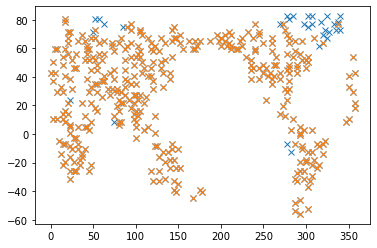

In [25]:
ds,la,ix = get_subset(ds,la_orig,region)
ds2 = ds2.isel(gridcell=ix)
ds3 = ds3.isel(gridcell=ix)

In [26]:
ds3

<xarray.Dataset>
Dimensions:         (ens: 373, gridcell: 370, time: 120)
Coordinates:
  * ens             (ens) int64 0 1 2 3 4 5 6 7 ... 366 367 368 369 370 371 372
  * time            (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Dimensions without coordinates: gridcell
Data variables:
    GPP             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    NPP             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    AR              (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    HR              (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    EFLX_LH_TOT     (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    FCTR            (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    FAREA_BURNED    (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    TOTVEGC         (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    TOTSOMC_1m      (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    QOVER           (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    QDRAI           (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    SOILWATER_10CM  (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    SNOWDP          (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    TSOI_10CM       (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    TLAI            (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    FSR             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    FSH             (ens, time, gridcell) float32 dask.array<chunksize=(1, 120, 370), meta=np.ndarray>
    grid1d_lat      (gridcell) float64 ...
    grid1d_lon      (gridcell) float64 ...
    key             (ens) object 'OAAT0000' 'OAAT0001' ... 'OAAT0398' 'OAAT0399'
    param           (ens) <U32 'default' 'taulnir' ... 'om_frac_sf'
    minmax          (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min'
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 07/05/21 09:14:28
    source:                                    Community Terrestrial Systems ...
    hostname:                                  cheyenne
    username:                                  djk2120
    version:                                   branch_tags/PPE.n08_ctsm5.1.de...
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   PPEn11_AF1905_OAAT0000
    Surface_dataset:                           surfdata_1.9x2.5_hist_16pfts_I...
    Initial_conditions_dataset:                PPEn11_AF1905_postSASU_OAAT000...
    PFT_physiological_constants_dataset:       OAAT0000.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:      

In [27]:
nx = 20

for datavar in data_vars:

    print(datavar)
    if datavar=='ALTMAX':
        xm_ctl,xi = calc_alt(ds)
        xm_c285,xi = calc_alt(ds2)
        xm_afpi,xi = calc_alt(ds3)

    else:
        xm_ctl,xa     = calc_mean(ds,datavar)
        xm_c285,xa    = calc_mean(ds2,datavar)
        xm_afpi,xa    = calc_mean(ds3,datavar)

    plt.figure(figsize=[10,8])
    
    plt.subplot(121)
    envpert,dxs = envpert_params(xm_ctl,xm_c285,ds,uniques)
    envpert_plot20(envpert,dxs,xm_ctl,xm_c285,uniques,datavar,'C285')
    
    plt.subplot(122)
    envpert,dxs = envpert_params(xm_ctl,xm_afpi,ds,uniques)
    envpert_plot20(envpert,dxs,xm_ctl,xm_afpi,uniques,datavar,'AFPI')
    
    plt.subplots_adjust(wspace=1.5)
    plt.subplots_adjust(left=0.22)
    
    ln =ds[datavar].attrs['long_name'].capitalize()
    if len(ln)<100:
        plt.figtext(0.562,0.95,ln,fontsize=12,ha='center')
    else:
        i = int(len(ln)/2)
        ln1 = ln[:i]
        ln2 = ln[i:]
        plt.figtext(0.562,0.98,ln1,fontsize=12,ha='center')
        plt.figtext(0.562,0.94,ln2,fontsize=12,ha='center')

    
    plt.savefig('../figs_'+region+'/'+datavar+'_'+region+'_envpert_top20.png')
    plt.close("all")


GPP
NPP
AR
HR
EFLX_LH_TOT
FCTR
FAREA_BURNED
TOTVEGC
TOTSOMC_1m
QOVER
QDRAI
SOILWATER_10CM
SNOWDP
TSOI_10CM
TLAI
FSR
FSH
